In [ ]:
%matplotlib inline


In [ ]:

# Load require dependency
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen
import cv2

In [ ]:
#Load required method for 
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

In [ ]:
train_data_input_path = [
    './output/car_detection_topview/train-00000-of-00001.tfrecord',
    './output/car_detection/train-00000-of-00001.tfrecord',
    ]
valid_data_input_path = [
    './output/car_detection_topview/valid-00000-of-00001.tfrecord',
    './output/car_detection/valid-00000-of-00001.tfrecord',
    ]
model_dir = './trained_model/'
export_dir ='./exported_model/'

In [ ]:
exp_config = exp_factory.get_exp_config('retinanet_resnetfpn_coco')

In [ ]:
batch_size = 21
num_classes = 1

HEIGHT, WIDTH = 256, 256
IMG_SIZE = [HEIGHT, WIDTH, 3]

# Backbone config.
exp_config.task.freeze_backbone = False
exp_config.task.annotation_file = ''

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
exp_config.task.model.detection_generatorSSction = exp_config.task.model.num_classes

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0

# Validation data config.
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

In [16]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


train_steps = 21200
exp_config.trainer.steps_per_loop = 100 # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = 100
exp_config.trainer.validation_interval = 100
exp_config.trainer.validation_steps =  100 # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 100
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 1e-4
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 2e-4

This may be broken in Colab.


In [17]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Done


In [18]:
with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

In [19]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.keys: {labels.keys()}')


images.shape: (21, 256, 256, 3)  images.dtype: tf.float32
labels.keys: dict_keys(['cls_targets', 'box_targets', 'anchor_boxes', 'cls_weights', 'box_weights', 'image_info'])


2025-02-28 11:13:58.777055: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
category_index={
    0: {
        'id': 0,
        'name': 'car'
       },
}
tf_ex_decoder = TfExampleDecoder()
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

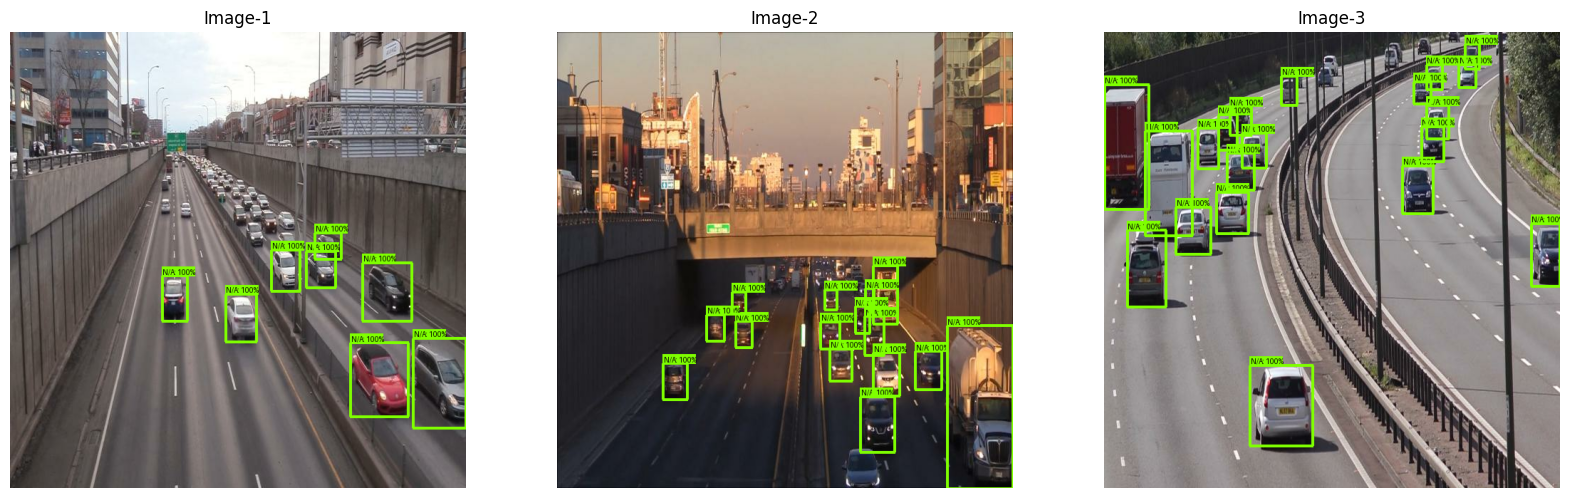

In [21]:
## show validation data
buffer_size = 20
num_of_examples = 3

raw_records = tf.data.TFRecordDataset(
    exp_config.task.train_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

In [22]:
# train and built model
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

restoring or initializing model...
restored model from ./trained_model/ckpt-21300.
restored from checkpoint: ./trained_model/ckpt-21300
 eval | step:  21300 | running 100 steps of evaluation...


2025-02-28 11:14:18.129685: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5112022636128020651
2025-02-28 11:14:18.129744: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1982202662034796917
2025-02-28 11:14:18.129761: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10687555140815069783
2025-02-28 11:14:18.129771: I tensorflow/core/framework/local_rendezvous.cc:428] Local rendezvous send item cancelled. Key hash: 6941188285061362087
2025-02-28 11:14:18.129782: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1035595222459655939
2025-02-28 11:14:18.129794: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12586183792783351613
2025-02-28 11:14:18.129813: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv i

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.71s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.639
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.053
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.164
 Av

In [24]:
#export model
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir)

INFO:tensorflow:Assets written to: ./exported_model/assets


INFO:tensorflow:Assets written to: ./exported_model/assets


In [25]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

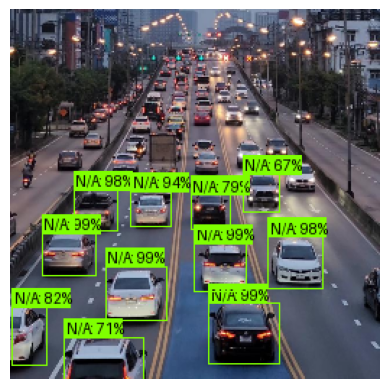

In [26]:
originimage = 1
def read_image(path):
    global originimage
    image_path = path  
    originimage = cv2.imread(image_path)
    originimage = cv2.cvtColor(originimage, cv2.COLOR_BGR2RGB)
    originimage = cv2.resize(originimage, (WIDTH, HEIGHT))

    image_tensor = tf.convert_to_tensor(originimage, dtype=tf.uint8)
    return image_tensor[tf.newaxis,...]

# # Run inference
image_test_path = "/home/giang/data/topviewcar/Vehicle_Detection_Image_Dataset/valid/images/5_mp4-5_jpg.rf.47c7656c79a6cfa7dbabfcaaeef94dea.jpg"
image_tensor = read_image(image_test_path)
result = model_fn(image_tensor)
visualization_utils.visualize_boxes_and_labels_on_image_array(
    originimage,  # Use original image for visualization
    result['detection_boxes'][0].numpy(),
    result['detection_classes'][0].numpy().astype(int),
    result['detection_scores'][0].numpy(),
    category_index=category_index,
    use_normalized_coordinates=False,
    max_boxes_to_draw=200,
    min_score_thresh=0.5,
    agnostic_mode=False,
    instance_masks=None,
    line_thickness=1
)
plt.imshow(originimage)
plt.axis('off')
plt.show()

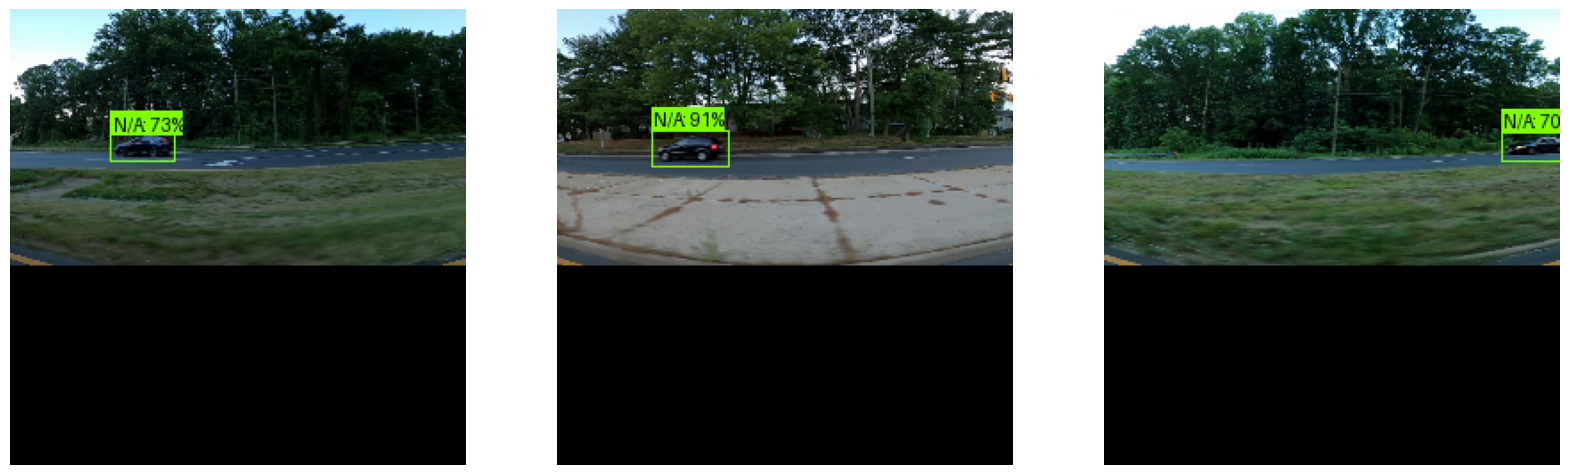

In [27]:
num_of_examples =3

test_ds = tf.data.TFRecordDataset(
    './output/car_detection/train-00000-of-00001.tfrecord').take(
        num_of_examples)

def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.20 # Change minimum score for threshold to see all bounding boxes confidences.

for i, serialized_example in enumerate(test_ds):
  plt.subplot(1, 3, i+1)
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=1)
  plt.imshow(image_np)
  plt.axis('off')

plt.show()